In [1]:
#import os
#import random
#import math
#from datetime import datetime
#from collections import Counter
#import pandas as pd
import numpy as np

import cv2
#from PIL import Image
#from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
#from sklearn.model_selection import train_test_split
#import xml.etree.ElementTree as ET
#
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import pandas as pd

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from task_models import CatDogsData, BB_model

In [3]:
model_path = "data/resnet34"
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
model.load_state_dict(torch.load(model_path))
model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [4]:
X_val, y_val = pd.read_pickle("data/x_val.pkl"), pd.read_pickle("data/y_val.pkl")

In [5]:
valid_ds = CatDogsData(X_val['new_path'],X_val['new_bb'],y_val)
valid_dl = DataLoader(valid_ds)

In [6]:
res_df = X_val.join(y_val)
pred_bb = []
indx=0
for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)

        _, pred = torch.max(out_class, 1)
        res_df.loc[res_df.index[indx], "pred_class"] = int(pred.item())
        pred_bb.append(out_bb.cpu().detach().numpy()[0])
        indx+=1

res_df["pred_bb"] = pred_bb
res_df

,new_path,new_bb,class,pred_class,pred_bb
3554,data/resized/Cats_Test880.png,"[0.0, 278.0, 107.0, 362.0]",1,1.0,"[7.4185324, 269.0091, 115.77523, 372.53235]"
3081,data/resized/Cats_Test454.png,"[23.0, 124.0, 130.0, 318.0]",1,1.0,"[5.2076206, 124.49328, 113.45743, 322.73032]"
2969,data/resized/Cats_Test3670.png,"[23.0, 244.0, 94.0, 382.0]",1,1.0,"[29.692541, 311.01538, 103.87998, 363.59564]"
2114,data/resized/Cats_Test2900.png,"[99.0, 126.0, 173.0, 215.0]",0,1.0,"[78.363976, 122.29852, 208.76991, 248.9898]"
3347,data/resized/Cats_Test694.png,"[0.0, 54.0, 172.0, 281.0]",0,0.0,"[12.497396, 70.54281, 225.96959, 308.07846]"
...,...,...,...,...,...
3587,data/resized/Cats_Test91.png,"[22.0, 89.0, 188.0, 322.0]",1,1.0,"[-1.06201, 97.868004, 211.17264, 346.12253]"
1506,data/resized/Cats_Test2353.png,"[82.0, 82.0, 185.0, 358.0]",1,1.0,"[53.065536, 65.04474, 234.61453, 375.95193]"
1452,data/resized/Cats_Test2304.png,"[28.0, 123.0, 219.0, 355.0]",1,1.0,"[5.768586, 105.32362, 205.43385, 398.5414]"
96,data/resized/Cats_Test1084.png,"[0.0, 87.0, 180.0, 267.0]",1,1.0,"[8.872995, 91.431366, 173.47313, 281.4639]"


In [7]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
print("acc score  ", accuracy_score(res_df["class"], res_df["pred_class"]))
print("f1 score   ", f1_score(res_df["class"], res_df["pred_class"]))
print("ROC AUC    ", roc_auc_score(res_df["class"], res_df["pred_class"]))

acc score   0.8943089430894309
f1 score    0.9245647969052224
ROC AUC     0.8528806584362141


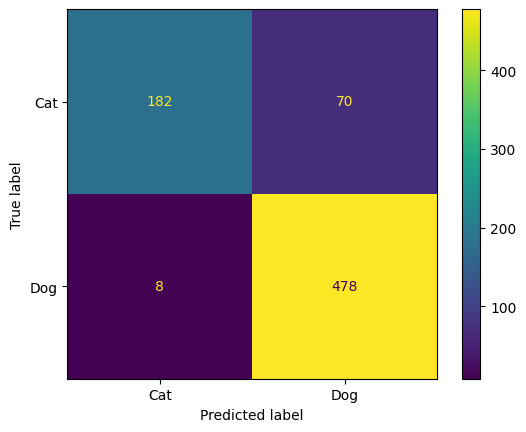

In [8]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(res_df["class"], res_df["pred_class"]), display_labels = ["Cat", "Dog"])

cm_display.plot()
plt.show()

## Видим что модель чаще ошибается на котах. Возможно сказывается небольшой дисбаланс классов.

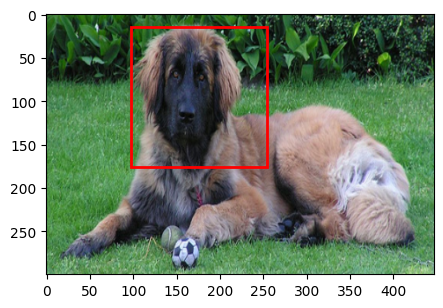

In [9]:
def plot_img_bbox(img, bb):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)

    x, y, width, height  = bb[1], bb[0], bb[2]-bb[0], bb[3]-bb[1]
    rect = Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
    a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
im_num =21
img = cv2.imread(res_df.loc[res_df.index[im_num], "new_path"])
img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img_res /= 255.0
plot_img_bbox(img_res, res_df.loc[res_df.index[im_num], "pred_bb"])

# Попробуем определить пароду собаки с помощью модели классификации, обученной на датасете с пародами собак

### Ноутбук с обучением можно найти в dogs_breed_pipeline. Саму модель можно скачать в репозитории https://huggingface.co/ulbashevsham/hometask_cats_and_dogs/tree/main и поместить в папку data в корне проекта

In [11]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_db = models.resnet50(pretrained=True)

# freeze all layers 
for param in model_db.parameters():
    model_db.requires_grad = False
    
# replace last layer with from 1000 classes to be 120 classes
model_db.fc = nn.Linear(2048, 120)
model_db = model_db.to(device=device)
model_db.load_state_dict(torch.load("data/dogs_breed"))
model_db.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Dog breed maping table
ids = pd.read_csv("breed_map.csv", sep=";")
ids

,id,breed
0,0,affenpinscher
1,1,afghan_hound
2,2,african_hunting_dog
3,3,airedale
4,4,american_staffordshire_terrier
...,...,...
115,115,welsh_springer_spaniel
116,116,west_highland_white_terrier
117,117,whippet
118,118,wire-haired_fox_terrier


In [15]:
res_df = X_val.join(y_val)
dog_breed = []
indx=0
for x, y_class, y_bb in valid_dl:
    x = x.cuda().float()
    y_class = y_class.cuda()
    if y_class.item()==1:
        _, pred = torch.max(model_db(x), 1)
        pred_id = pred.item()
        dog_breed.append(ids[ids.id==pred_id]["breed"].values[0])
    else:
        dog_breed.append("cat")
               
res_df["dog_breed"] = dog_breed        
res_df

,new_path,new_bb,class,dog_breed
3554,data/resized/Cats_Test880.png,"[0.0, 278.0, 107.0, 362.0]",1,eskimo_dog
3081,data/resized/Cats_Test454.png,"[23.0, 124.0, 130.0, 318.0]",1,pomeranian
2969,data/resized/Cats_Test3670.png,"[23.0, 244.0, 94.0, 382.0]",1,german_short-haired_pointer
2114,data/resized/Cats_Test2900.png,"[99.0, 126.0, 173.0, 215.0]",0,cat
3347,data/resized/Cats_Test694.png,"[0.0, 54.0, 172.0, 281.0]",0,cat
...,...,...,...,...
3587,data/resized/Cats_Test91.png,"[22.0, 89.0, 188.0, 322.0]",1,yorkshire_terrier
1506,data/resized/Cats_Test2353.png,"[82.0, 82.0, 185.0, 358.0]",1,rhodesian_ridgeback
1452,data/resized/Cats_Test2304.png,"[28.0, 123.0, 219.0, 355.0]",1,pug
96,data/resized/Cats_Test1084.png,"[0.0, 87.0, 180.0, 267.0]",1,great_pyrenees


### К сожалению я не очень разбираюсь в породах собак и не смогу провалидировать результаты работы модели, тут нужен специалист) Поэтому оставлю результат в виде таблицы с присвоенной породой. 